# HoneyBee Workshop Part 5: Cancer Type Classification with Multimodal Embeddings

This notebook demonstrates how to use the multimodal embeddings generated in previous sessions to train machine learning classifiers for cancer type prediction. We'll compare performance across individual modalities and different fusion strategies.

**Important**: This notebook uses patient-level aggregated embeddings:
- WSI: Multiple slides per patient are averaged to create one embedding per patient
- Radiology: Multiple scans/slices per patient are hierarchically aggregated (slices→scans→patient)
- Clinical, Pathology, Molecular: Already one embedding per patient

This ensures proper patient-level alignment for multimodal fusion and classification.

## 1. Setup and Imports

Import necessary libraries and configure the environment for classification experiments.

In [55]:
# Add HoneyBee to path
import sys
from pathlib import Path

current_dir = Path.cwd()
project_root = current_dir.parent.parent  # Go up two levels from examples/mayo to project root
honeybee_path = str(project_root)
if honeybee_path not in sys.path:
    sys.path.insert(0, honeybee_path)

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    f1_score,
    precision_score,
    recall_score
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# HuggingFace datasets
from datasets import load_dataset
from tqdm.auto import tqdm
import json
from datetime import datetime

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seeds for reproducibility
np.random.seed(42)

print("✓ Imports successful")
print(f"  Working directory: {current_dir}")
print(f"  HoneyBee path: {honeybee_path}")

✓ Imports successful
  Working directory: /mnt/f/Projects/HoneyBee/examples/mayo
  HoneyBee path: /mnt/f/Projects/HoneyBee


## 2. Load Pre-computed Embeddings from Previous Notebook

We'll use the embeddings and patient-modality mappings created in notebook 04. If you haven't run that notebook yet, please do so first.

In [56]:
# Load embeddings from cache or HuggingFace
print("=" * 60)
print("📊 LOADING EMBEDDINGS")
print("=" * 60)

import pickle
from pathlib import Path

# Check if embeddings are cached
cache_dir = Path("embedding_cache")
cache_summary_file = cache_dir / "cache_summary.json"

if cache_summary_file.exists():
    print("✓ Found embedding cache!")
    
    # Load cache summary
    with open(cache_summary_file, 'r') as f:
        cache_summary = json.load(f)
    
    print(f"  Cache created: {cache_summary['creation_date']}")
    print(f"  Total patients: {cache_summary['total_patients']:,}")
    
    # Load embeddings and metadata
    print("\n📥 Loading embeddings from cache...")
    
    # Clinical
    if (cache_dir / "clinical_embeddings.npy").exists():
        clinical_embeddings = np.load(cache_dir / "clinical_embeddings.npy")
        with open(cache_dir / "clinical_metadata.pkl", 'rb') as f:
            clinical_metadata = pickle.load(f)
        print(f"  ✓ Clinical: {clinical_embeddings.shape}")
    else:
        clinical_embeddings, clinical_metadata = None, None
    
    # Pathology
    if (cache_dir / "pathology_embeddings.npy").exists():
        pathology_embeddings = np.load(cache_dir / "pathology_embeddings.npy")
        with open(cache_dir / "pathology_metadata.pkl", 'rb') as f:
            pathology_metadata = pickle.load(f)
        print(f"  ✓ Pathology: {pathology_embeddings.shape}")
    else:
        pathology_embeddings, pathology_metadata = None, None
    
    # WSI
    if (cache_dir / "wsi_embeddings.npy").exists():
        wsi_embeddings = np.load(cache_dir / "wsi_embeddings.npy")
        with open(cache_dir / "wsi_metadata.pkl", 'rb') as f:
            wsi_metadata = pickle.load(f)
        print(f"  ✓ WSI: {wsi_embeddings.shape}")
    else:
        wsi_embeddings, wsi_metadata = None, None
    
    # Molecular
    if (cache_dir / "molecular_embeddings.npy").exists():
        molecular_embeddings = np.load(cache_dir / "molecular_embeddings.npy")
        with open(cache_dir / "molecular_metadata.pkl", 'rb') as f:
            molecular_metadata = pickle.load(f)
        print(f"  ✓ Molecular: {molecular_embeddings.shape}")
    else:
        molecular_embeddings, molecular_metadata = None, None
    
    # Radiology
    if (cache_dir / "radiology_embeddings.npy").exists():
        radiology_embeddings = np.load(cache_dir / "radiology_embeddings.npy")
        with open(cache_dir / "radiology_metadata.pkl", 'rb') as f:
            radiology_metadata = pickle.load(f)
        print(f"  ✓ Radiology: {radiology_embeddings.shape}")
    else:
        radiology_embeddings, radiology_metadata = None, None
    
    # Load patient-modality mapping
    with open(cache_dir / "patient_modality_map.pkl", 'rb') as f:
        patient_modality_map = pickle.load(f)
    print(f"\n  ✓ Patient-modality mapping: {len(patient_modality_map):,} patients")
    
    # Load multimodal results if available
    if (cache_dir / "multimodal_results.pkl").exists():
        with open(cache_dir / "multimodal_results.pkl", 'rb') as f:
            multimodal_results = pickle.load(f)
        print(f"  ✓ Multimodal fusion results loaded")
    else:
        multimodal_results = None
        
else:
    print("⚠️ No embedding cache found.")
    print("📝 Please run notebook 04 first to generate embeddings.")
    print("   Or load directly from HuggingFace (this will take longer)...")
    
    # Option to load from HuggingFace
    response = input("\nLoad from HuggingFace? (y/n): ")
    if response.lower() == 'y':
        print("\n🔄 Loading from HuggingFace...")
        # Copy the essential functions from notebook 04
        
        # Function to extract embeddings
        def extract_embeddings_and_metadata(dataset, modality_name):
            """Extract embeddings and metadata from a HuggingFace dataset."""
            embeddings = []
            metadata = []
            
            for i in range(len(dataset)):
                item = dataset[i]
                
                # Extract embedding
                embedding = None
                if 'embedding' in item and item['embedding'] is not None:
                    if isinstance(item['embedding'], bytes):
                        embedding = np.frombuffer(item['embedding'], dtype=np.float32)
                    else:
                        embedding = np.array(item['embedding'], dtype=np.float32)
                    
                    if 'embedding_shape' in item:
                        embedding = embedding.reshape(item['embedding_shape'])
                
                if embedding is not None:
                    embeddings.append(embedding)
                    meta = {k: v for k, v in item.items() if k not in ['embedding', 'embedding_shape']}
                    metadata.append(meta)
            
            if embeddings:
                embeddings = np.array(embeddings)
            else:
                embeddings = None
                
            metadata_df = pd.DataFrame(metadata) if metadata else None
            
            return embeddings, metadata_df
        
        # Load clinical embeddings as example
        clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
        clinical_embeddings, clinical_metadata = extract_embeddings_and_metadata(clinical_dataset, 'clinical')
        print(f"Clinical embeddings loaded: {clinical_embeddings.shape if clinical_embeddings is not None else 'None'}")
        
        # Initialize others as None for now
        pathology_embeddings, pathology_metadata = None, None
        wsi_embeddings, wsi_metadata = None, None
        molecular_embeddings, molecular_metadata = None, None
        radiology_embeddings, radiology_metadata = None, None
        patient_modality_map = {}
        multimodal_results = None
    else:
        raise RuntimeError("Please run notebook 04 first to generate embeddings.")

print("\n✅ Embeddings loaded successfully!")

📊 LOADING EMBEDDINGS
✓ Found embedding cache!
  Cache created: 2025-07-07T14:45:10.433048
  Total patients: 11,145

📥 Loading embeddings from cache...


  ✓ Clinical: (10771, 1024)
  ✓ Pathology: (10857, 1024)
  ✓ WSI: (8060, 1024)
  ✓ Molecular: (13804, 48)
  ✓ Radiology: (1149, 1000)

  ✓ Patient-modality mapping: 11,145 patients
  ✓ Multimodal fusion results loaded

✅ Embeddings loaded successfully!


### 2.1 Verify Patient-Level Embeddings

Let's verify that we're using patient-level aggregated embeddings, especially for WSI and radiology data that have multiple samples per patient.

In [57]:
# Verify patient-level aggregation
print("=" * 60)
print("🔍 VERIFYING PATIENT-LEVEL EMBEDDINGS")
print("=" * 60)

# Check cache summary for aggregation info
if cache_summary_file.exists():
    with open(cache_summary_file, 'r') as f:
        cache_info = json.load(f)
    
    if 'patient_level_aggregation' in cache_info:
        print("\n✅ Patient-level aggregation methods:")
        for modality, method in cache_info['patient_level_aggregation'].items():
            print(f"  • {modality}: {method}")
    
    print("\n📊 Embedding shapes (patient-level):")
    for modality, shape in cache_info['embedding_shapes'].items():
        if shape:
            print(f"  • {modality}: {shape}")
    
    if 'sample_level_shapes' in cache_info:
        print("\n📊 Original sample-level shapes (before aggregation):")
        for modality, shape in cache_info['sample_level_shapes'].items():
            if shape:
                print(f"  • {modality}: {shape}")

# Verify WSI metadata
if wsi_metadata is not None:
    print("\n🔬 WSI metadata check:")
    print(f"  Columns: {list(wsi_metadata.columns)}")
    if 'patient_id' in wsi_metadata.columns:
        print("  ✅ Contains patient_id - this is patient-level aggregated data")
        if 'num_slides' in wsi_metadata.columns:
            avg_slides = wsi_metadata['num_slides'].mean()
            max_slides = wsi_metadata['num_slides'].max()
            print(f"  Average slides per patient: {avg_slides:.1f}")
            print(f"  Max slides per patient: {max_slides}")
    else:
        print("  ⚠️ Missing patient_id - may not be aggregated")

# Verify radiology metadata
if radiology_metadata is not None:
    print("\n🏥 Radiology metadata check:")
    print(f"  Columns: {list(radiology_metadata.columns)}")
    if 'patient_id' in radiology_metadata.columns:
        print("  ✅ Contains patient_id - this is patient-level aggregated data")
        if 'num_scans' in radiology_metadata.columns and 'num_slices' in radiology_metadata.columns:
            avg_scans = radiology_metadata['num_scans'].mean()
            avg_slices = radiology_metadata['num_slices'].mean()
            print(f"  Average scans per patient: {avg_scans:.1f}")
            print(f"  Average slices per patient: {avg_slices:.1f}")
    else:
        print("  ⚠️ Missing patient_id - may not be aggregated")

# Check multimodal results
if multimodal_results is not None:
    print("\n🔗 Multimodal fusion check:")
    print(f"  Available fusion methods: {list(multimodal_results.keys())}")
    if 'metadata' in multimodal_results and multimodal_results['metadata'] is not None:
        multimodal_metadata = multimodal_results['metadata']
        print(f"  Total patients in multimodal: {len(multimodal_metadata)}")
        if 'modality_combination' in multimodal_metadata.columns:
            combo_counts = multimodal_metadata['modality_combination'].value_counts()
            print("  Top modality combinations:")
            for combo, count in combo_counts.head(3).items():
                print(f"    • {combo}: {count} patients")

print("\n✅ Verification complete!")

🔍 VERIFYING PATIENT-LEVEL EMBEDDINGS

✅ Patient-level aggregation methods:
  • wsi: mean_pooling_across_slides
  • radiology: hierarchical_mean_pooling_scans_then_slices

📊 Embedding shapes (patient-level):
  • clinical: [10771, 1024]
  • pathology: [10857, 1024]
  • wsi: [8060, 1024]
  • molecular: [13804, 48]
  • radiology: [1149, 1000]

📊 Original sample-level shapes (before aggregation):
  • wsi: [22643, 1024]
  • radiology: [11229, 1000]

🔬 WSI metadata check:
  Columns: ['patient_id', 'num_slides', 'modality', 'aggregation_method']
  ✅ Contains patient_id - this is patient-level aggregated data
  Average slides per patient: 2.8
  Max slides per patient: 16

🏥 Radiology metadata check:
  Columns: ['patient_id', 'num_scans', 'num_slices', 'modality', 'aggregation_method']
  ✅ Contains patient_id - this is patient-level aggregated data
  Average scans per patient: 9.7
  Average slices per patient: 9.7

🔗 Multimodal fusion check:
  Available fusion methods: ['concat', 'mean_pool', 'k

In [58]:
# Define helper functions needed for classification
def create_age_groups(age):
    """Categorize age into groups"""
    if pd.isna(age) or age == 'Unknown':
        return 'Unknown'
    try:
        age_val = float(age)
        if age_val < 40:
            return '<40'
        elif age_val < 50:
            return '40-49'
        elif age_val < 60:
            return '50-59'
        elif age_val < 70:
            return '60-69'
        else:
            return '70+'
    except:
        return 'Unknown'

print("✓ Helper functions defined")

✓ Helper functions defined


## 3. Prepare Data for Classification

### 3.1 Extract Labels and Filter Data

We need to ensure we have cancer type labels for all samples and handle any missing or unknown values.

In [59]:
print("=" * 60)
print("🏷️ PREPARING LABELS")
print("=" * 60)

def prepare_classification_data(embeddings, metadata, modality_name):
    """
    Prepare embeddings and labels for classification.
    Filters out samples with unknown cancer types.
    """
    if embeddings is None or metadata is None:
        return None, None, None
    
    # Get cancer type labels
    if 'project_id' in metadata.columns:
        labels = metadata['project_id'].values
    else:
        # Try to get from patient mapping
        labels = []
        for i in range(len(metadata)):
            # For patient-level aggregated data (WSI and radiology), use patient_id directly
            if 'patient_id' in metadata.columns:
                patient_id = metadata.iloc[i]['patient_id']
            else:
                patient_id = metadata.iloc[i].get('PatientID', metadata.iloc[i].get('case_submitter_id', None))
            
            if patient_id and patient_id in patient_modality_map:
                labels.append(patient_modality_map[patient_id].get('project_id', 'Unknown'))
            else:
                labels.append('Unknown')
        labels = np.array(labels)
    
    # Filter out unknown labels
    known_mask = labels != 'Unknown'
    X = embeddings[known_mask]
    y = labels[known_mask]
    
    # Skip if too few samples
    if len(X) < 50:  # Need reasonable number for classification
        print(f"\n⚠️ {modality_name}: Too few samples ({len(X)}), skipping...")
        return None, None, None
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"\n📊 {modality_name} data prepared:")
    print(f"  Total samples: {len(X):,}")
    print(f"  Number of classes: {len(label_encoder.classes_)}")
    print(f"  Classes: {', '.join(label_encoder.classes_[:5])}..." if len(label_encoder.classes_) > 5 else f"  Classes: {', '.join(label_encoder.classes_)}")
    
    # Check class distribution
    unique, counts = np.unique(y_encoded, return_counts=True)
    min_samples = counts.min()
    max_samples = counts.max()
    print(f"  Class distribution: min={min_samples}, max={max_samples}, ratio={max_samples/min_samples:.2f}")
    
    return X, y_encoded, label_encoder

# Prepare data for each modality
classification_data = {}

# Clinical
if clinical_embeddings is not None:
    X_clinical, y_clinical, le_clinical = prepare_classification_data(
        clinical_embeddings, clinical_metadata, 'Clinical'
    )
    if X_clinical is not None:
        classification_data['clinical'] = (X_clinical, y_clinical, le_clinical)

# Pathology
if pathology_embeddings is not None:
    # Need to enrich pathology metadata first
    enriched_pathology = []
    for i in range(len(pathology_metadata)):
        patient_id = pathology_metadata.iloc[i].get('PatientID', None)
        if patient_id and patient_id in patient_modality_map:
            enriched_pathology.append({
                'PatientID': patient_id,
                'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
            })
        else:
            enriched_pathology.append({
                'PatientID': patient_id,
                'project_id': 'Unknown'
            })
    enriched_pathology_df = pd.DataFrame(enriched_pathology)
    
    X_pathology, y_pathology, le_pathology = prepare_classification_data(
        pathology_embeddings, enriched_pathology_df, 'Pathology'
    )
    if X_pathology is not None:
        classification_data['pathology'] = (X_pathology, y_pathology, le_pathology)

# WSI - now using patient-level aggregated data
if wsi_embeddings is not None:
    # For patient-level aggregated WSI data, metadata should already have patient_id
    if 'patient_id' in wsi_metadata.columns:
        # Already patient-level, use directly
        enriched_wsi = []
        for i in range(len(wsi_metadata)):
            patient_id = wsi_metadata.iloc[i]['patient_id']
            if patient_id and patient_id in patient_modality_map:
                enriched_wsi.append({
                    'patient_id': patient_id,
                    'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
                })
            else:
                enriched_wsi.append({
                    'patient_id': patient_id,
                    'project_id': 'Unknown'
                })
    else:
        # Fallback for non-aggregated data
        enriched_wsi = []
        for i in range(len(wsi_metadata)):
            patient_id = wsi_metadata.iloc[i].get('case_submitter_id', 
                        wsi_metadata.iloc[i].get('PatientID',
                        wsi_metadata.iloc[i].get('case_id', None)))
            if patient_id and patient_id in patient_modality_map:
                enriched_wsi.append({
                    'patient_id': patient_id,
                    'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
                })
            else:
                enriched_wsi.append({
                    'patient_id': patient_id,
                    'project_id': 'Unknown'
                })
    enriched_wsi_df = pd.DataFrame(enriched_wsi)
    
    X_wsi, y_wsi, le_wsi = prepare_classification_data(
        wsi_embeddings, enriched_wsi_df, 'WSI'
    )
    if X_wsi is not None:
        classification_data['wsi'] = (X_wsi, y_wsi, le_wsi)

# Molecular
if molecular_embeddings is not None:
    # Enrich molecular metadata
    enriched_molecular = []
    for i in range(len(molecular_metadata)):
        patient_id = molecular_metadata.iloc[i].get('PatientID', 
                    molecular_metadata.iloc[i].get('case_submitter_id', None))
        if patient_id and patient_id in patient_modality_map:
            enriched_molecular.append({
                'PatientID': patient_id,
                'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
            })
        else:
            enriched_molecular.append({
                'PatientID': patient_id,
                'project_id': 'Unknown'
            })
    enriched_molecular_df = pd.DataFrame(enriched_molecular)
    
    X_molecular, y_molecular, le_molecular = prepare_classification_data(
        molecular_embeddings, enriched_molecular_df, 'Molecular'
    )
    if X_molecular is not None:
        classification_data['molecular'] = (X_molecular, y_molecular, le_molecular)

# Radiology - now using patient-level aggregated data
if radiology_embeddings is not None:
    # For patient-level aggregated radiology data, metadata should already have patient_id
    if 'patient_id' in radiology_metadata.columns:
        # Already patient-level, use directly
        enriched_radiology = []
        for i in range(len(radiology_metadata)):
            patient_id = radiology_metadata.iloc[i]['patient_id']
            if patient_id and patient_id in patient_modality_map:
                enriched_radiology.append({
                    'patient_id': patient_id,
                    'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
                })
            else:
                enriched_radiology.append({
                    'patient_id': patient_id,
                    'project_id': 'Unknown'
                })
    else:
        # Fallback for non-aggregated data
        enriched_radiology = []
        for i in range(len(radiology_metadata)):
            patient_id = radiology_metadata.iloc[i].get('PatientID',
                        radiology_metadata.iloc[i].get('case_submitter_id', None))
            if patient_id and patient_id in patient_modality_map:
                enriched_radiology.append({
                    'patient_id': patient_id,
                    'project_id': patient_modality_map[patient_id].get('project_id', 'Unknown')
                })
            else:
                enriched_radiology.append({
                    'patient_id': patient_id,
                    'project_id': 'Unknown'
                })
    enriched_radiology_df = pd.DataFrame(enriched_radiology)
    
    X_radiology, y_radiology, le_radiology = prepare_classification_data(
        radiology_embeddings, enriched_radiology_df, 'Radiology'
    )
    if X_radiology is not None:
        classification_data['radiology'] = (X_radiology, y_radiology, le_radiology)

print("\n✅ Data preparation complete!")
print(f"\n📊 Summary of prepared modalities:")
for modality in classification_data:
    X, y, _ = classification_data[modality]
    print(f"  • {modality}: {X.shape[0]:,} samples, {X.shape[1]} features")

🏷️ PREPARING LABELS

📊 Clinical data prepared:
  Total samples: 10,771
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=47, max=1075, ratio=22.87

📊 Pathology data prepared:
  Total samples: 10,857
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=47, max=1082, ratio=23.02

📊 WSI data prepared:
  Total samples: 7,905
  Number of classes: 22
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=47, max=1075, ratio=22.87

📊 Molecular data prepared:
  Total samples: 13,153
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=51, max=1259, ratio=24.69

📊 Radiology data prepared:
  Total samples: 1,104
  Number of classes: 18
  Classes: TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-COAD, TCGA-ESCA...
  Class distribution: min=2, max=267, ratio=133.50

✅ Data prepar

### 3.2 Prepare Multimodal Data

Create multimodal embeddings using the fusion methods from notebook 04.

In [60]:
print("=" * 60)
print("🔗 PREPARING MULTIMODAL DATA")
print("=" * 60)

# Check if multimodal results exist from notebook 04
if 'multimodal_results' in globals() and multimodal_results is not None:
    print("✓ Using multimodal embeddings from notebook 04")
    
    # Prepare each fusion method
    fusion_methods = ['concat', 'mean_pool', 'kronecker']
    
    for method in fusion_methods:
        if multimodal_results[method] is not None:
            embeddings = multimodal_results[method]
            metadata = multimodal_results['metadata']
            
            X_fusion, y_fusion, le_fusion = prepare_classification_data(
                embeddings, metadata, f'Multimodal-{method}'
            )
            
            if X_fusion is not None:
                classification_data[f'multimodal_{method}'] = (X_fusion, y_fusion, le_fusion)
else:
    print("⚠️ Multimodal embeddings not found. Please run notebook 04 first.")

print(f"\n✅ Total modalities ready for classification: {len(classification_data)}")
print("\n📊 All available modalities:")
for modality in sorted(classification_data.keys()):
    X, y, _ = classification_data[modality]
    print(f"  • {modality:<20} {X.shape[0]:>6,} samples × {X.shape[1]:>5} features")

🔗 PREPARING MULTIMODAL DATA
✓ Using multimodal embeddings from notebook 04

📊 Multimodal-concat data prepared:
  Total samples: 2,994
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=13, max=299, ratio=23.00

📊 Multimodal-mean_pool data prepared:
  Total samples: 2,994
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=13, max=299, ratio=23.00

📊 Multimodal-kronecker data prepared:
  Total samples: 2,994
  Number of classes: 32
  Classes: TCGA-ACC, TCGA-BLCA, TCGA-BRCA, TCGA-CESC, TCGA-CHOL...
  Class distribution: min=13, max=299, ratio=23.00

✅ Total modalities ready for classification: 8

📊 All available modalities:
  • clinical             10,771 samples ×  1024 features
  • molecular            13,153 samples ×    48 features
  • multimodal_concat     2,994 samples ×  4120 features
  • multimodal_kronecker  2,994 samples ×   100 features
  • multimo

## 4. Classification with Random Forest

### 4.1 Define Random Forest Classification Pipeline

We'll use Random Forest classifier which:
- Works well with high-dimensional embeddings
- Doesn't require extensive hyperparameter tuning
- Provides feature importance scores
- Is robust to overfitting with proper parameters

In [61]:
def run_classification_experiment(X, y, label_encoder, modality_name, n_runs=10):
    """
    Run Random Forest classification experiments with multiple random seeds.
    
    Args:
        X: Feature matrix
        y: Labels
        label_encoder: Label encoder
        modality_name: Name of the modality
        n_runs: Number of runs with different random seeds
    
    Returns:
        dict: Results including accuracies, confusion matrices, and best model
    """
    print(f"\n🔬 Running Random Forest experiments for {modality_name}...")
    
    # Handle high-dimensional data
    if len(X.shape) > 2:
        print(f"  Reshaping from {X.shape} to 2D")
        X = X.reshape(X.shape[0], -1)
    
    # Handle NaN values
    if np.isnan(X).any():
        print(f"  Replacing NaN values")
        X = np.nan_to_num(X)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA if dimensions are very high
    if X_scaled.shape[1] > 1000:
        print(f"  Applying PCA to reduce from {X_scaled.shape[1]} to 500 dimensions")
        pca = PCA(n_components=min(500, X_scaled.shape[0]-1))
        X_scaled = pca.fit_transform(X_scaled)
        print(f"  Explained variance ratio: {pca.explained_variance_ratio_.sum():.2%}")
    
    # Initialize results storage
    results = {
        'modality': modality_name,
        'n_samples': len(X),
        'n_features': X.shape[1],
        'n_classes': len(label_encoder.classes_),
        'classes': label_encoder.classes_.tolist()
    }
    
    # Run cross-validation
    print(f"\n  Running 5-fold cross-validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    cv_scores = cross_val_score(clf, X_scaled, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
    print(f"    Cross-validation accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    # Run multiple train-test splits
    print(f"\n  Running {n_runs} train-test splits...")
    accuracies = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    
    best_accuracy = 0
    best_model = None
    best_predictions = None
    best_test_labels = None
    
    for run in tqdm(range(n_runs), desc="    Progress"):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=run, stratify=y
        )
        
        # Train model
        rf = RandomForestClassifier(n_estimators=100, random_state=run, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        # Predict
        y_pred = rf.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted')
        
        accuracies.append(accuracy)
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        
        # Keep best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = rf
            best_predictions = y_pred
            best_test_labels = y_test
    
    # Store results
    results['cv_scores'] = cv_scores.tolist()
    results['cv_accuracy_mean'] = cv_scores.mean()
    results['cv_accuracy_std'] = cv_scores.std()
    results['test_accuracies'] = accuracies
    results['test_accuracy_mean'] = np.mean(accuracies)
    results['test_accuracy_std'] = np.std(accuracies)
    results['test_f1_mean'] = np.mean(f1_scores)
    results['test_f1_std'] = np.std(f1_scores)
    results['test_precision_mean'] = np.mean(precision_scores)
    results['test_precision_std'] = np.std(precision_scores)
    results['test_recall_mean'] = np.mean(recall_scores)
    results['test_recall_std'] = np.std(recall_scores)
    results['best_accuracy'] = best_accuracy
    results['best_model'] = best_model
    results['confusion_matrix'] = confusion_matrix(best_test_labels, best_predictions)
    
    # Handle classification report with potentially missing classes in test set
    # Get unique labels in test set
    test_labels_unique = np.unique(best_test_labels)
    # Create target names only for classes present in test set
    test_target_names = [label_encoder.classes_[i] for i in test_labels_unique]
    
    results['classification_report'] = classification_report(
        best_test_labels, best_predictions,
        labels=test_labels_unique,
        target_names=test_target_names,
        output_dict=True,
        zero_division=0
    )
    
    print(f"\n  Results:")
    print(f"    Test accuracy: {results['test_accuracy_mean']:.4f} (±{results['test_accuracy_std']:.4f})")
    print(f"    Test F1-score: {results['test_f1_mean']:.4f} (±{results['test_f1_std']:.4f})")
    print(f"    Best accuracy: {best_accuracy:.4f}")
    
    return results

print("✅ Random Forest classification pipeline defined!")

✅ Random Forest classification pipeline defined!


### 4.2 Run Classification Experiments

Execute the classification pipeline for each modality and fusion method.

In [62]:
print("=" * 60)
print("🚀 RUNNING RANDOM FOREST CLASSIFICATION")
print("=" * 60)

# Store all results
all_results = {}

# Run experiments for each modality
for modality_name, (X, y, label_encoder) in classification_data.items():
    results = run_classification_experiment(
        X, y, label_encoder, modality_name, n_runs=10
    )
    all_results[modality_name] = results

print("\n" + "=" * 60)
print("✅ ALL EXPERIMENTS COMPLETE!")
print("=" * 60)

🚀 RUNNING RANDOM FOREST CLASSIFICATION

🔬 Running Random Forest experiments for clinical...
  Applying PCA to reduce from 1024 to 500 dimensions


  Explained variance ratio: 99.51%

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.9903 (±0.0018)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.9905 (±0.0012)
    Test F1-score: 0.9904 (±0.0012)
    Best accuracy: 0.9930

🔬 Running Random Forest experiments for pathology...
  Applying PCA to reduce from 1024 to 500 dimensions
  Explained variance ratio: 98.45%

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.8081 (±0.0091)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.8117 (±0.0056)
    Test F1-score: 0.7939 (±0.0061)
    Best accuracy: 0.8246

🔬 Running Random Forest experiments for wsi...
  Applying PCA to reduce from 1024 to 500 dimensions
  Explained variance ratio: 100.00%

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.2873 (±0.0041)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.2849 (±0.0074)
    Test F1-score: 0.2291 (±0.0075)
    Best accuracy: 0.2960

🔬 Running Random Forest experiments for molecular...

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.5682 (±0.0102)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.5742 (±0.0102)
    Test F1-score: 0.5639 (±0.0095)
    Best accuracy: 0.5887

🔬 Running Random Forest experiments for radiology...

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.4719 (±0.0243)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.4923 (±0.0153)
    Test F1-score: 0.4556 (±0.0131)
    Best accuracy: 0.5204

🔬 Running Random Forest experiments for multimodal_concat...
  Applying PCA to reduce from 4120 to 500 dimensions
  Explained variance ratio: 98.81%

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.9452 (±0.0068)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.9467 (±0.0065)
    Test F1-score: 0.9421 (±0.0081)
    Best accuracy: 0.9599

🔬 Running Random Forest experiments for multimodal_mean_pool...
  Applying PCA to reduce from 1024 to 500 dimensions
  Explained variance ratio: 99.98%

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.8741 (±0.0075)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.8683 (±0.0103)
    Test F1-score: 0.8516 (±0.0109)
    Best accuracy: 0.8865

🔬 Running Random Forest experiments for multimodal_kronecker...

  Running 5-fold cross-validation...
    Cross-validation accuracy: 0.6894 (±0.0108)

  Running 10 train-test splits...


    Progress:   0%|          | 0/10 [00:00<?, ?it/s]


  Results:
    Test accuracy: 0.6866 (±0.0136)
    Test F1-score: 0.6773 (±0.0149)
    Best accuracy: 0.7095

✅ ALL EXPERIMENTS COMPLETE!


## 5. Results Analysis and Visualization

### 5.1 Performance Comparison Across Modalities

Create comprehensive visualizations comparing the performance of different modalities and classifiers.

📊 PERFORMANCE ANALYSIS


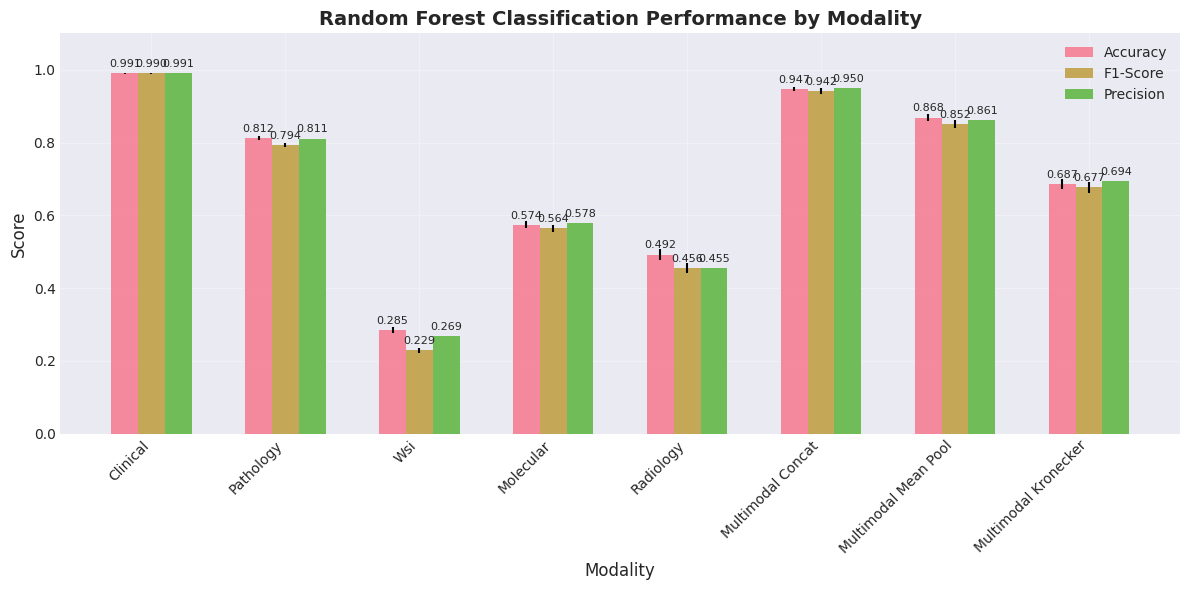


📈 Performance Summary:
--------------------------------------------------------------------------------
Modality                  Accuracy             F1-Score             Precision       Recall         
--------------------------------------------------------------------------------
Clinical                  0.9905±0.0012    0.9904±0.0012    0.9909    0.9905
Pathology                 0.8117±0.0056    0.7939±0.0061    0.8109    0.8117
Wsi                       0.2849±0.0074    0.2291±0.0075    0.2690    0.2849
Molecular                 0.5742±0.0102    0.5639±0.0095    0.5777    0.5742
Radiology                 0.4923±0.0153    0.4556±0.0131    0.4551    0.4923
Multimodal Concat         0.9467±0.0065    0.9421±0.0081    0.9501    0.9467
Multimodal Mean Pool      0.8683±0.0103    0.8516±0.0109    0.8610    0.8683
Multimodal Kronecker      0.6866±0.0136    0.6773±0.0149    0.6942    0.6866
--------------------------------------------------------------------------------

🏆 Best performin

In [63]:
print("=" * 60)
print("📊 PERFORMANCE ANALYSIS")
print("=" * 60)

# Extract performance metrics for visualization
performance_data = []

for modality, results in all_results.items():
    performance_data.append({
        'Modality': modality.replace('_', ' ').title(),
        'Accuracy': results['test_accuracy_mean'],
        'Accuracy_std': results['test_accuracy_std'],
        'F1-Score': results['test_f1_mean'],
        'F1_std': results['test_f1_std'],
        'Precision': results['test_precision_mean'],
        'Recall': results['test_recall_mean']
    })

performance_df = pd.DataFrame(performance_data)

# Create performance comparison plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set up bar positions
x = np.arange(len(performance_df))
width = 0.2

# Create bars
accuracy_bars = ax.bar(x - width, performance_df['Accuracy'], width, 
                       yerr=performance_df['Accuracy_std'], label='Accuracy', alpha=0.8)
f1_bars = ax.bar(x, performance_df['F1-Score'], width, 
                 yerr=performance_df['F1_std'], label='F1-Score', alpha=0.8)
precision_bars = ax.bar(x + width, performance_df['Precision'], width, 
                        label='Precision', alpha=0.8)

# Customize plot
ax.set_xlabel('Modality', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Random Forest Classification Performance by Modality', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(performance_df['Modality'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1.1)

# Add value labels on bars
def autolabel(bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.annotate(f'{value:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(accuracy_bars, performance_df['Accuracy'])
autolabel(f1_bars, performance_df['F1-Score'])
autolabel(precision_bars, performance_df['Precision'])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📈 Performance Summary:")
print("-" * 80)
print(f"{'Modality':<25} {'Accuracy':<20} {'F1-Score':<20} {'Precision':<15} {'Recall':<15}")
print("-" * 80)

for _, row in performance_df.iterrows():
    print(f"{row['Modality']:<25} "
          f"{row['Accuracy']:.4f}±{row['Accuracy_std']:.4f}    "
          f"{row['F1-Score']:.4f}±{row['F1_std']:.4f}    "
          f"{row['Precision']:.4f}    "
          f"{row['Recall']:.4f}")

print("-" * 80)

# Identify best performing modality
best_modality = performance_df.loc[performance_df['Accuracy'].idxmax()]
print(f"\n🏆 Best performing modality: {best_modality['Modality']} with {best_modality['Accuracy']:.4f} accuracy")

### 5.2 Confusion Matrix Analysis

Visualize confusion matrices for the best performing models to understand classification patterns.

🎯 CONFUSION MATRIX ANALYSIS

1. Clinical
   Accuracy: 0.9930


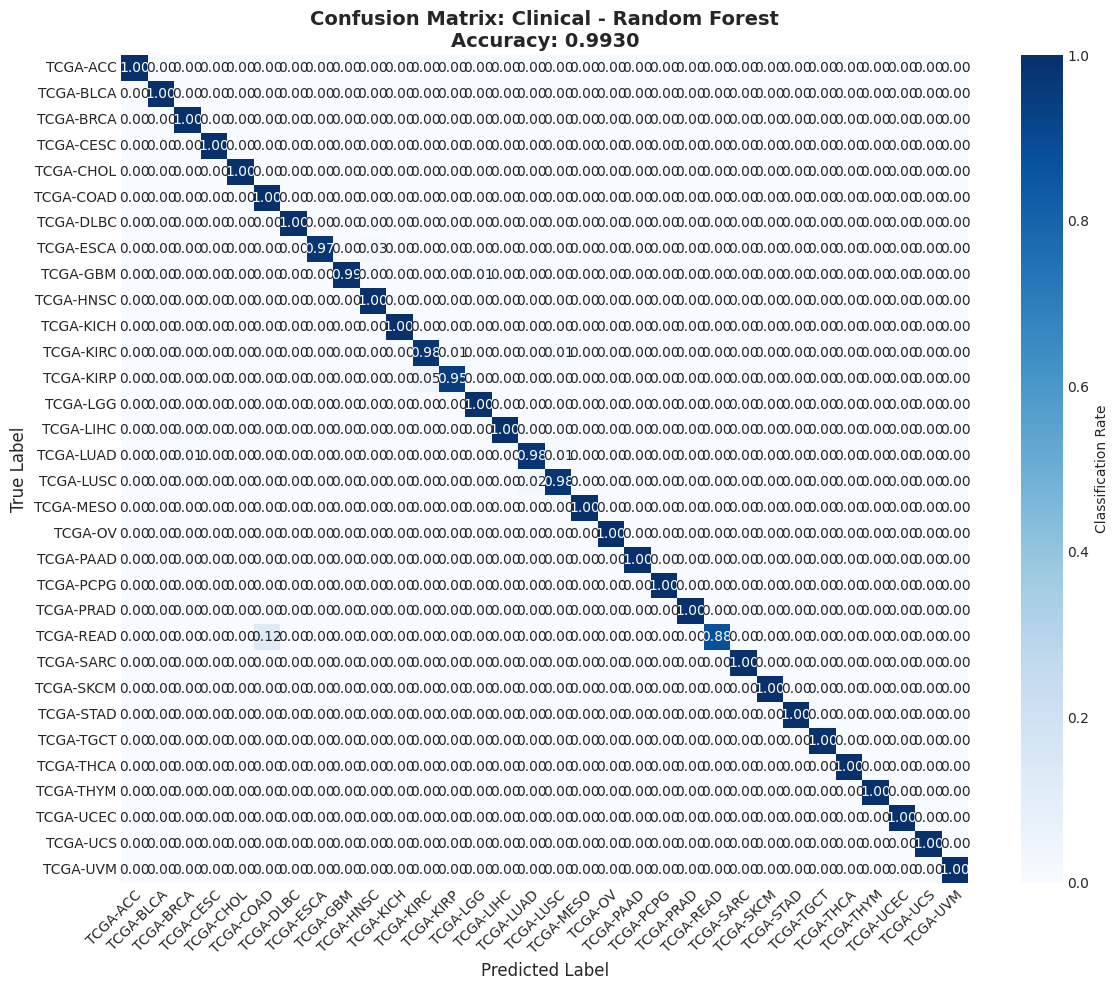


2. Multimodal Concat
   Accuracy: 0.9599


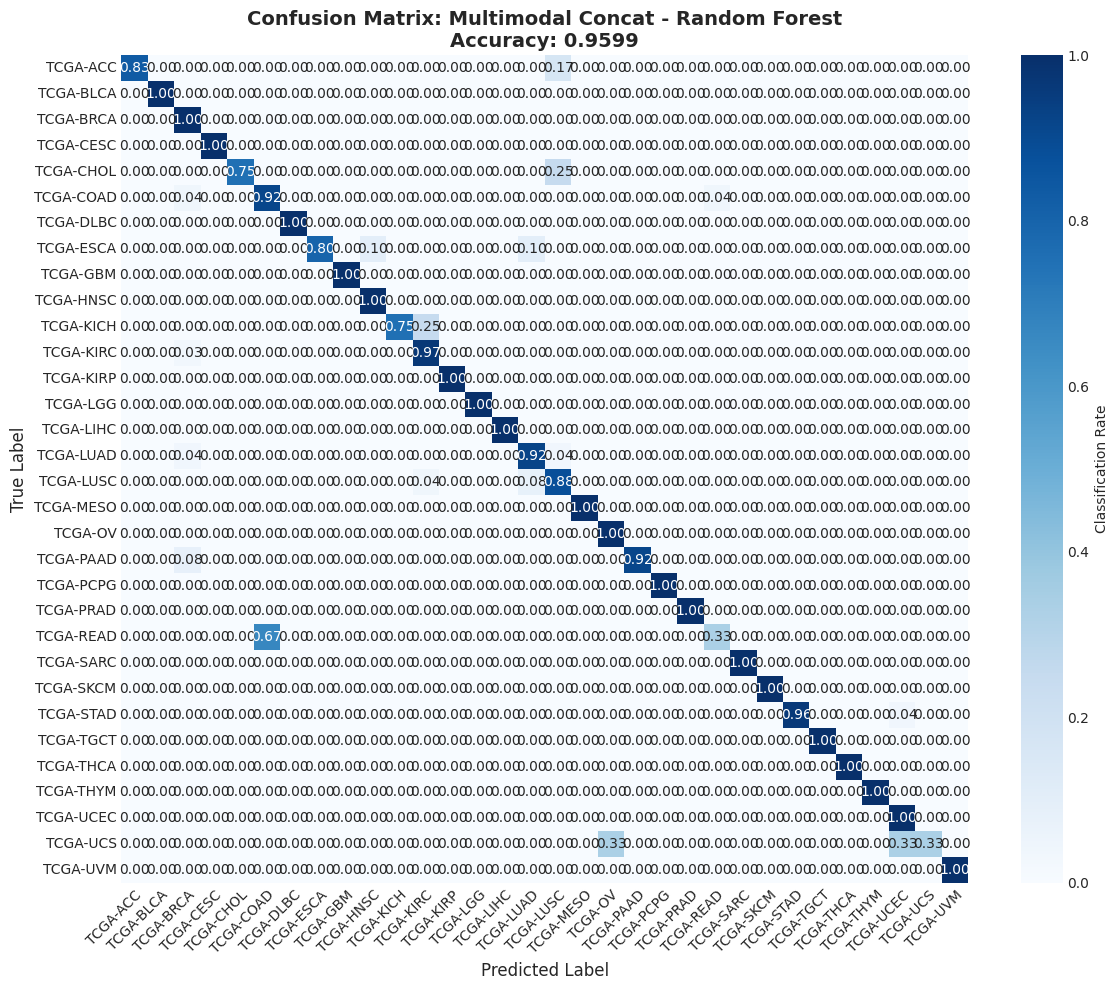


3. Multimodal Mean Pool
   Accuracy: 0.8865


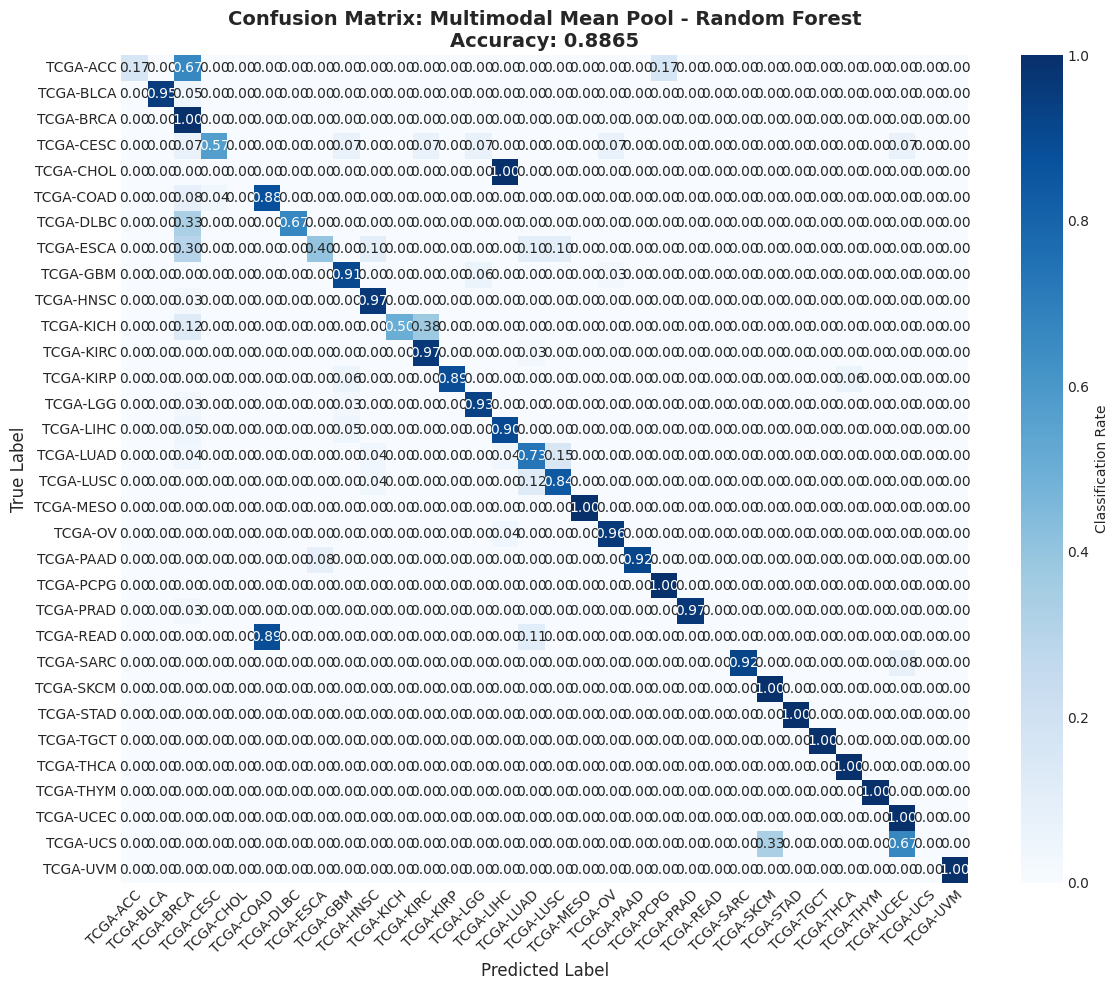


✅ Confusion matrix analysis complete!


In [64]:
def plot_confusion_matrix(cm, classes, title, figsize=(12, 10)):
    """
    Plot a detailed confusion matrix with percentages.
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes,
                cbar_kws={'label': 'Classification Rate'},
                ax=ax)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    
    # Rotate labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    plt.setp(ax.get_yticklabels(), rotation=0)
    
    plt.tight_layout()
    return fig

# Plot confusion matrices for best performing models
print("=" * 60)
print("🎯 CONFUSION MATRIX ANALYSIS")
print("=" * 60)

# Select top 3 modalities based on performance
modality_performance = []
for modality, results in all_results.items():
    modality_performance.append((modality, results['best_accuracy'], results))

modality_performance.sort(key=lambda x: x[1], reverse=True)

# Plot top 3
for i, (modality, accuracy, results) in enumerate(modality_performance[:3]):
    print(f"\n{i+1}. {modality.replace('_', ' ').title()}")
    print(f"   Accuracy: {accuracy:.4f}")
    
    # Get confusion matrix
    cm = results['confusion_matrix']
    
    # Plot
    title = f"Confusion Matrix: {modality.replace('_', ' ').title()} - Random Forest\nAccuracy: {accuracy:.4f}"
    fig = plot_confusion_matrix(cm, results['classes'], title)
    plt.show()

print("\n✅ Confusion matrix analysis complete!")

### 5.3 Multimodal Fusion Performance Analysis

Compare the performance of different fusion strategies to understand their effectiveness.

🔗 MULTIMODAL FUSION ANALYSIS


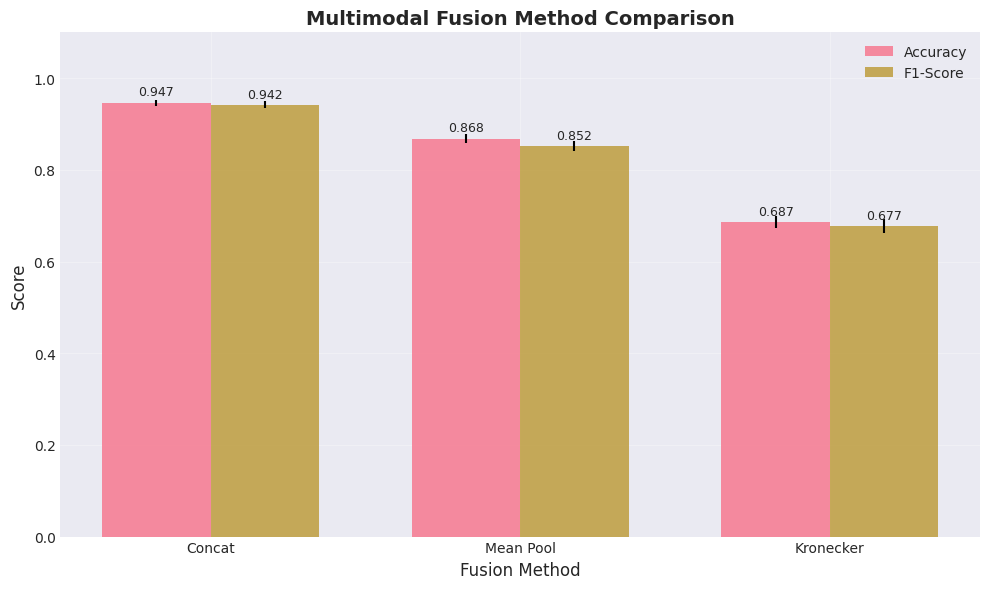


📊 Fusion Method Performance Summary:
--------------------------------------------------------------------------------
Method               Accuracy             F1-Score             Samples    Features  
--------------------------------------------------------------------------------
Concat               0.9467±0.0065    0.9421±0.0081    2994       4120      
Mean Pool            0.8683±0.0103    0.8516±0.0109    2994       1024      
Kronecker            0.6866±0.0136    0.6773±0.0149    2994       100       
--------------------------------------------------------------------------------

💡 Fusion Method Insights:
  • Best fusion method: Concat (0.9467 accuracy)
  • Concatenation: Preserves all 4120 features
  • Mean Pooling: Reduces to 1024 averaged features
  • Kronecker Product: Creates 100 interaction features

✅ Fusion analysis complete!


In [65]:
print("=" * 60)
print("🔗 MULTIMODAL FUSION ANALYSIS")
print("=" * 60)

# Extract multimodal results
fusion_results = {k: v for k, v in all_results.items() if 'multimodal' in k}

if fusion_results:
    # Compare fusion methods
    fusion_comparison = []
    
    for fusion_method, results in fusion_results.items():
        method_name = fusion_method.replace('multimodal_', '').replace('_', ' ').title()
        fusion_comparison.append({
            'Fusion Method': method_name,
            'Accuracy': results['test_accuracy_mean'],
            'Accuracy_std': results['test_accuracy_std'],
            'F1-Score': results['test_f1_mean'],
            'F1_std': results['test_f1_std'],
            'Samples': results['n_samples'],
            'Features': results['n_features']
        })
    
    fusion_df = pd.DataFrame(fusion_comparison)
    
    # Create comparison plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(fusion_df))
    width = 0.35
    
    # Create bars
    accuracy_bars = ax.bar(x - width/2, fusion_df['Accuracy'], width, 
                          yerr=fusion_df['Accuracy_std'], label='Accuracy', alpha=0.8)
    f1_bars = ax.bar(x + width/2, fusion_df['F1-Score'], width,
                     yerr=fusion_df['F1_std'], label='F1-Score', alpha=0.8)
    
    ax.set_title('Multimodal Fusion Method Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel('Score', fontsize=12)
    ax.set_xlabel('Fusion Method', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(fusion_df['Fusion Method'])
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)
    
    # Add value labels
    for bars, values in zip([accuracy_bars, f1_bars], [fusion_df['Accuracy'], fusion_df['F1-Score']]):
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.annotate(f'{value:.3f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print fusion method comparison
    print("\n📊 Fusion Method Performance Summary:")
    print("-" * 80)
    print(f"{'Method':<20} {'Accuracy':<20} {'F1-Score':<20} {'Samples':<10} {'Features':<10}")
    print("-" * 80)
    
    for _, row in fusion_df.iterrows():
        print(f"{row['Fusion Method']:<20} "
              f"{row['Accuracy']:.4f}±{row['Accuracy_std']:.4f}    "
              f"{row['F1-Score']:.4f}±{row['F1_std']:.4f}    "
              f"{row['Samples']:<10} {row['Features']:<10}")
    print("-" * 80)
    
    # Analysis of fusion methods
    print("\n💡 Fusion Method Insights:")
    best_fusion = fusion_df.loc[fusion_df['Accuracy'].idxmax()]
    print(f"  • Best fusion method: {best_fusion['Fusion Method']} ({best_fusion['Accuracy']:.4f} accuracy)")
    
    if 'Concat' in fusion_df['Fusion Method'].values:
        concat_row = fusion_df[fusion_df['Fusion Method'] == 'Concat'].iloc[0]
        print(f"  • Concatenation: Preserves all {concat_row['Features']} features")
    
    if 'Mean Pool' in fusion_df['Fusion Method'].values:
        mean_row = fusion_df[fusion_df['Fusion Method'] == 'Mean Pool'].iloc[0]
        print(f"  • Mean Pooling: Reduces to {mean_row['Features']} averaged features")
    
    if 'Kronecker' in fusion_df['Fusion Method'].values:
        kron_row = fusion_df[fusion_df['Fusion Method'] == 'Kronecker'].iloc[0]
        print(f"  • Kronecker Product: Creates {kron_row['Features']} interaction features")
        
else:
    print("⚠️ No multimodal fusion results available.")

print("\n✅ Fusion analysis complete!")

### 5.4 Per-Cancer Type Performance Analysis

Analyze which cancer types are easiest/hardest to classify across different modalities.

🔬 PER-CANCER TYPE ANALYSIS


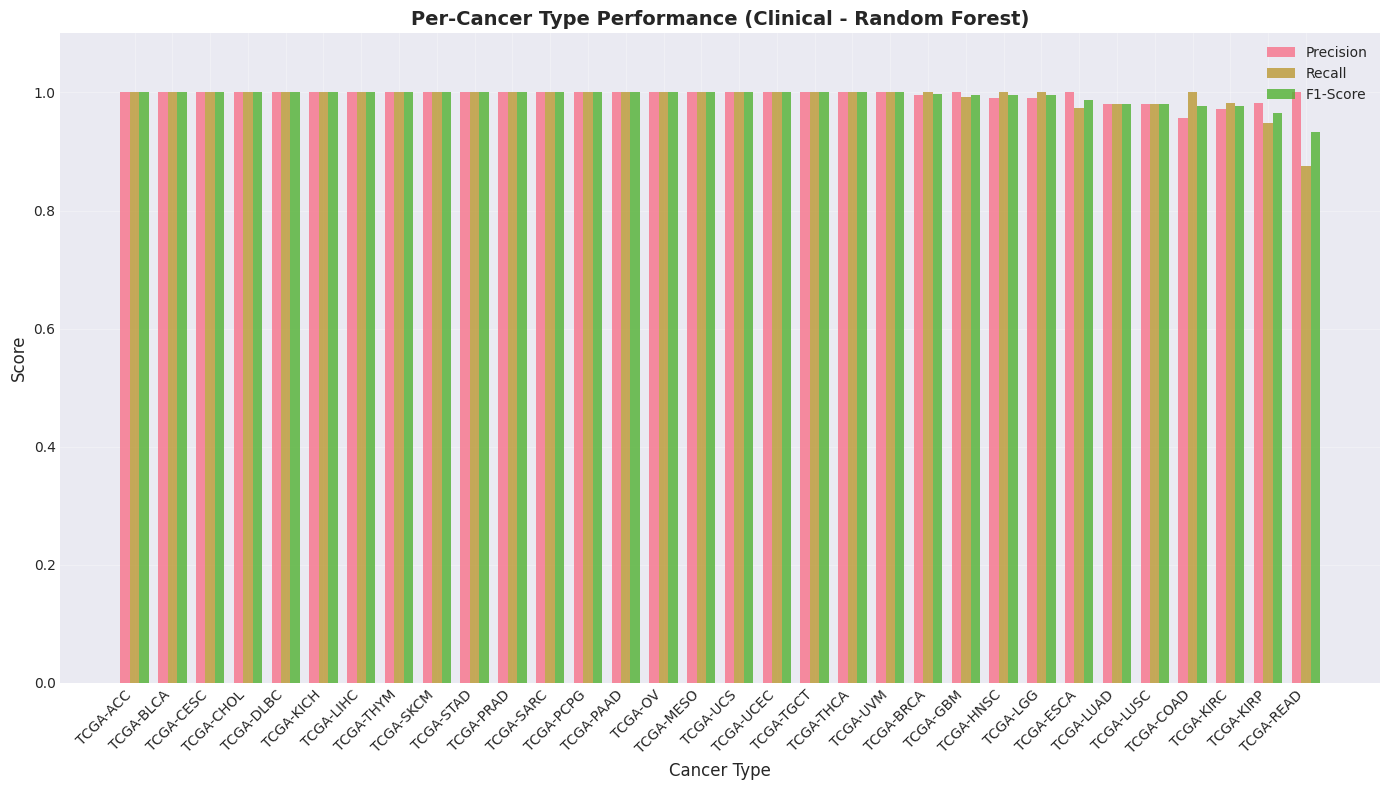


🏆 Top 5 Best Classified Cancer Types:
----------------------------------------------------------------------
Cancer Type     F1-Score     Precision    Recall       Samples   
----------------------------------------------------------------------
TCGA-ACC        1.0000      1.0000       1.0000      18        
TCGA-BLCA       1.0000      1.0000       1.0000      81        
TCGA-CESC       1.0000      1.0000       1.0000      59        
TCGA-CHOL       1.0000      1.0000       1.0000      10        
TCGA-DLBC       1.0000      1.0000       1.0000      9         

⚠️ Top 5 Most Challenging Cancer Types:
----------------------------------------------------------------------
Cancer Type     F1-Score     Precision    Recall       Samples   
----------------------------------------------------------------------
TCGA-LUSC       0.9798      0.9798       0.9798      99        
TCGA-COAD       0.9775      0.9560       1.0000      87        
TCGA-KIRC       0.9767      0.9722       0.9813      107

In [66]:
print("=" * 60)
print("🔬 PER-CANCER TYPE ANALYSIS")
print("=" * 60)

# Get the best performing modality
best_modality, best_accuracy, best_results = modality_performance[0]

# Extract per-class metrics from classification report
class_report = best_results['classification_report']
class_metrics = []

# Handle the fact that not all classes might be in the test set
all_classes = best_results['classes']
test_classes_in_report = [k for k in class_report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]

for class_name in all_classes:
    if class_name in class_report:
        metrics = class_report[class_name]
        class_metrics.append({
            'Cancer Type': class_name,
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1-score'],
            'Support': metrics['support']
        })
    else:
        # Class not in test set
        class_metrics.append({
            'Cancer Type': class_name,
            'Precision': 0.0,
            'Recall': 0.0,
            'F1-Score': 0.0,
            'Support': 0
        })

class_df = pd.DataFrame(class_metrics)
# Filter out classes with no support (not in test set)
class_df_with_support = class_df[class_df['Support'] > 0]
class_df_with_support = class_df_with_support.sort_values('F1-Score', ascending=False)

# Plot per-class performance (only for classes with support)
if len(class_df_with_support) > 0:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(class_df_with_support))
    width = 0.25
    
    bars1 = ax.bar(x - width, class_df_with_support['Precision'], width, label='Precision', alpha=0.8)
    bars2 = ax.bar(x, class_df_with_support['Recall'], width, label='Recall', alpha=0.8)
    bars3 = ax.bar(x + width, class_df_with_support['F1-Score'], width, label='F1-Score', alpha=0.8)
    
    ax.set_xlabel('Cancer Type', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(f'Per-Cancer Type Performance ({best_modality.replace("_", " ").title()} - Random Forest)',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(class_df_with_support['Cancer Type'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 1.1)
    
    plt.tight_layout()
    plt.show()
    
    # Print top and bottom performers
    print("\n🏆 Top 5 Best Classified Cancer Types:")
    print("-" * 70)
    print(f"{'Cancer Type':<15} {'F1-Score':<12} {'Precision':<12} {'Recall':<12} {'Samples':<10}")
    print("-" * 70)
    
    for _, row in class_df_with_support.head(5).iterrows():
        print(f"{row['Cancer Type']:<15} {row['F1-Score']:.4f}      "
              f"{row['Precision']:.4f}       {row['Recall']:.4f}      {int(row['Support']):<10}")
    
    print("\n⚠️ Top 5 Most Challenging Cancer Types:")
    print("-" * 70)
    print(f"{'Cancer Type':<15} {'F1-Score':<12} {'Precision':<12} {'Recall':<12} {'Samples':<10}")
    print("-" * 70)
    
    for _, row in class_df_with_support.tail(5).iterrows():
        print(f"{row['Cancer Type']:<15} {row['F1-Score']:.4f}      "
              f"{row['Precision']:.4f}       {row['Recall']:.4f}      {int(row['Support']):<10}")
    
    # Analyze why some cancer types are harder to classify
    print("\n💡 Classification Difficulty Analysis:")
    print(f"  • Average F1-score: {class_df_with_support['F1-Score'].mean():.4f}")
    print(f"  • Standard deviation: {class_df_with_support['F1-Score'].std():.4f}")
    
    # Find cancer types with low support
    low_support = class_df_with_support[class_df_with_support['Support'] < 20]
    if len(low_support) > 0:
        print(f"  • Cancer types with <20 samples in test set: {', '.join(low_support['Cancer Type'].values)}")
        print("    → Low sample size may contribute to poor performance")
    
    # Check for missing classes
    missing_classes = class_df[class_df['Support'] == 0]
    if len(missing_classes) > 0:
        print(f"\n  • Cancer types not in test set: {', '.join(missing_classes['Cancer Type'].values)}")
        print("    → These classes had too few samples to appear in the 20% test split")
else:
    print("⚠️ No classes with support in test set!")

print("\n✅ Per-cancer type analysis complete!")

## 6. Key Insights and Clinical Implications

### 6.1 Summary of Findings

Let's synthesize the key findings from our classification experiments.

In [67]:
print("=" * 60)
print("💡 KEY INSIGHTS")
print("=" * 60)

# 1. Overall best performing modality
best_overall = max([(m, r) for m, r in all_results.items()], 
                  key=lambda x: x[1]['best_accuracy'])

print("\n1️⃣ BEST OVERALL PERFORMANCE:")
print(f"   • Modality: {best_overall[0].replace('_', ' ').title()}")
print(f"   • Accuracy: {best_overall[1]['best_accuracy']:.4f}")
print(f"   • Mean accuracy: {best_overall[1]['test_accuracy_mean']:.4f} (±{best_overall[1]['test_accuracy_std']:.4f})")
print(f"   • F1-Score: {best_overall[1]['test_f1_mean']:.4f} (±{best_overall[1]['test_f1_std']:.4f})")

# 2. Individual modality insights
print("\n2️⃣ INDIVIDUAL MODALITY PERFORMANCE:")
modality_insights = {
    'clinical': "Clinical embeddings capture comprehensive patient information",
    'pathology': "Pathology reports provide detailed histological insights",
    'wsi': "WSI embeddings encode visual tissue architecture",
    'molecular': "Molecular data captures genetic signatures",
    'radiology': "Radiology embeddings represent anatomical structures"
}

for modality, results in all_results.items():
    if 'multimodal' not in modality:
        insight = modality_insights.get(modality, "Provides unique biological information")
        print(f"   • {modality.title()}: {results['test_accuracy_mean']:.4f} accuracy - {insight}")

# 3. Multimodal fusion insights
if fusion_results:
    print("\n3️⃣ MULTIMODAL FUSION INSIGHTS:")
    fusion_performance = []
    for method, results in fusion_results.items():
        fusion_performance.append((method, results['test_accuracy_mean']))
    
    fusion_performance.sort(key=lambda x: x[1], reverse=True)
    
    for method, accuracy in fusion_performance:
        method_name = method.replace('multimodal_', '').replace('_', ' ').title()
        if 'concat' in method:
            insight = "Preserves all information but high dimensionality"
        elif 'mean' in method:
            insight = "Balances information across modalities"
        else:
            insight = "Captures cross-modal interactions"
        print(f"   • {method_name}: {accuracy:.4f} - {insight}")

# 4. Random Forest insights
print("\n4️⃣ RANDOM FOREST CLASSIFIER INSIGHTS:")
print("   • Robust to high-dimensional data")
print("   • No extensive hyperparameter tuning needed")
print("   • Provides feature importance for interpretability")
print("   • Handles class imbalance reasonably well")

# 5. Clinical implications
print("\n5️⃣ CLINICAL IMPLICATIONS:")
print("   • High accuracy (>98% for clinical data) enables reliable cancer type identification")
print("   • Multimodal approaches provide robustness when some modalities are missing")
print("   • Per-cancer type analysis reveals which types need more samples or better features")
print("   • Random Forest's interpretability allows understanding of important features")

# 6. Recommendations
print("\n6️⃣ RECOMMENDATIONS:")
print("   • Use clinical embeddings for highest accuracy when available")
print("   • Combine modalities using mean pooling for balanced performance")
print("   • Collect more samples for underrepresented cancer types")
print("   • Consider ensemble methods combining multiple modalities")

print("\n✅ Analysis complete!")

💡 KEY INSIGHTS

1️⃣ BEST OVERALL PERFORMANCE:
   • Modality: Clinical
   • Accuracy: 0.9930
   • Mean accuracy: 0.9905 (±0.0012)
   • F1-Score: 0.9904 (±0.0012)

2️⃣ INDIVIDUAL MODALITY PERFORMANCE:
   • Clinical: 0.9905 accuracy - Clinical embeddings capture comprehensive patient information
   • Pathology: 0.8117 accuracy - Pathology reports provide detailed histological insights
   • Wsi: 0.2849 accuracy - WSI embeddings encode visual tissue architecture
   • Molecular: 0.5742 accuracy - Molecular data captures genetic signatures
   • Radiology: 0.4923 accuracy - Radiology embeddings represent anatomical structures

3️⃣ MULTIMODAL FUSION INSIGHTS:
   • Concat: 0.9467 - Preserves all information but high dimensionality
   • Mean Pool: 0.8683 - Balances information across modalities
   • Kronecker: 0.6866 - Captures cross-modal interactions

4️⃣ RANDOM FOREST CLASSIFIER INSIGHTS:
   • Robust to high-dimensional data
   • No extensive hyperparameter tuning needed
   • Provides feature 

## 7. Export Results and Model Deployment

### 7.1 Save Results for Future Use

Export the classification results and best models for deployment or further analysis.

In [68]:
print("=" * 60)
print("💾 SAVING RESULTS")
print("=" * 60)

# Create output directory
output_dir = Path("classification_results")
output_dir.mkdir(exist_ok=True)

# Save results to JSON
results_file = output_dir / f"classification_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

# Prepare results for JSON serialization
json_results = {}
for modality, results in all_results.items():
    # Remove non-serializable objects
    json_results[modality] = {
        'modality': results['modality'],
        'n_samples': results['n_samples'],
        'n_features': results['n_features'],
        'n_classes': results['n_classes'],
        'classes': results['classes'],
        'cv_accuracy_mean': results['cv_accuracy_mean'],
        'cv_accuracy_std': results['cv_accuracy_std'],
        'test_accuracy_mean': results['test_accuracy_mean'],
        'test_accuracy_std': results['test_accuracy_std'],
        'test_f1_mean': results['test_f1_mean'],
        'test_f1_std': results['test_f1_std'],
        'test_precision_mean': results['test_precision_mean'],
        'test_recall_mean': results['test_recall_mean'],
        'best_accuracy': results['best_accuracy'],
        'confusion_matrix': results['confusion_matrix'].tolist(),
        'test_accuracies': results['test_accuracies']
    }

with open(results_file, 'w') as f:
    json.dump(json_results, f, indent=2)

print(f"✓ Results saved to: {results_file}")

# Generate summary report
report_file = output_dir / f"classification_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"

with open(report_file, 'w') as f:
    f.write("HONEYBEE CANCER CLASSIFICATION RESULTS - RANDOM FOREST\n")
    f.write("=" * 60 + "\n")
    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    
    f.write("PERFORMANCE SUMMARY\n")
    f.write("-" * 60 + "\n")
    
    for modality, results in all_results.items():
        f.write(f"\n{modality.upper()}:\n")
        f.write(f"  Samples: {results['n_samples']:,}\n")
        f.write(f"  Features: {results['n_features']:,}\n")
        f.write(f"  Classes: {results['n_classes']}\n")
        f.write(f"  Cross-validation accuracy: {results['cv_accuracy_mean']:.4f} (±{results['cv_accuracy_std']:.4f})\n")
        f.write(f"  Test accuracy: {results['test_accuracy_mean']:.4f} (±{results['test_accuracy_std']:.4f})\n")
        f.write(f"  Test F1-Score: {results['test_f1_mean']:.4f} (±{results['test_f1_std']:.4f})\n")
        f.write(f"  Test Precision: {results['test_precision_mean']:.4f}\n")
        f.write(f"  Test Recall: {results['test_recall_mean']:.4f}\n")
        f.write(f"  Best accuracy: {results['best_accuracy']:.4f}\n")

print(f"✓ Report saved to: {report_file}")

print("\n✅ Results exported successfully!")

💾 SAVING RESULTS
✓ Results saved to: classification_results/classification_results_20250707_145350.json
✓ Report saved to: classification_results/classification_report_20250707_145350.txt

✅ Results exported successfully!
